<a href="https://colab.research.google.com/github/mbalejo/ear-recognition-as_of_2020/blob/main/Unconstrained_Ear_Recognition_through_SOTA_Machine_Learning_Models_(as_of_early_2021).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Codes for Unconstrained Ear Recognition using SOTA ML Models (as of early 2021)*

*Marwin B. Alejo*

This notebook contain straightforward codeblocks hence, required libraries will be installed when each cell was executed. Most important of this libraries is the TIMM library which contain the necessary scripts in order for this codes to fetch the necessary pretrained models of the concerned networks of this study.

Moreover, the raw Ear Dataset used in this study may be downloaded from [Mendeley Data page](https://data.mendeley.com/datasets/yws3v3mwx3/4) or in this [folder](https://drive.google.com/drive/folders/1YzVIXU5WyfIWh3NMnhp4Mp9vNxk_CULy?usp=sharing).


**Sample Ear Images of EarVN1.0**

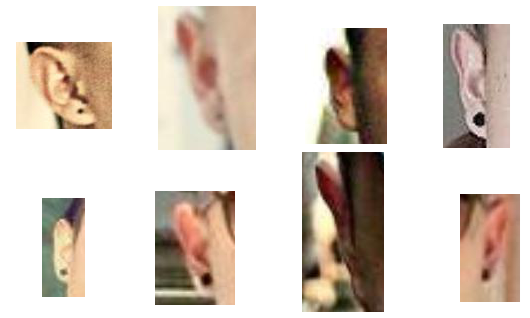

**Preliminary Results**
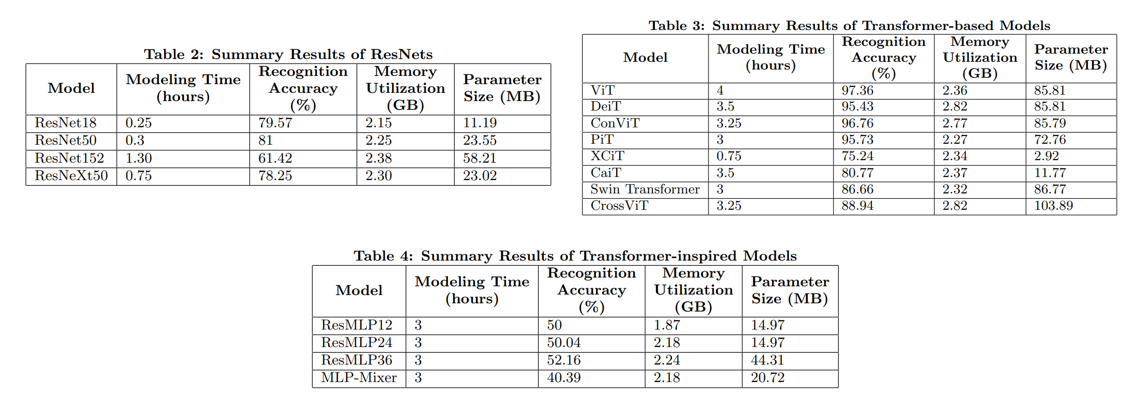

#**ResNet18**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models.mlp_mixer import ResBlock, Affine, _create_mixer, _cfg
from timm.models import create_model, resnet
from timm.models.resnet import BasicBlock, Bottleneck, ResNet, _create_resnet
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/resnet18.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def resnet18(pretrained=False, **kwargs):
  """Constructs a ResNet-18 model."""
  model_args = dict(block=BasicBlock, layers=[2, 2, 2, 2], **kwargs)
  return model

model = create_model(
    'resnet18',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()
    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**ResNet50**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models.mlp_mixer import ResBlock, Affine, _create_mixer, _cfg
from timm.models import create_model, resnet
from timm.models.resnet import BasicBlock, Bottleneck, ResNet, _create_resnet
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/resnet50.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def resnet50(pretrained=False, **kwargs):
  """Constructs a ResNet-50 model"""
  model_args = dict(block=Bottleneck, layers=[3, 4, 6, 3],  **kwargs)
  model = _create_resnet('resnet50', pretrained, **model_args)
  return model

model = create_model(
    'resnet50',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')


#**ResNet152**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models.mlp_mixer import ResBlock, Affine, _create_mixer, _cfg
from timm.models import create_model, resnet
from timm.models.resnet import BasicBlock, Bottleneck, ResNet, _create_resnet
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/resnet152.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def resnet152d(pretrained=False, **kwargs):
  model_args = dict(block=Bottleneck, layers=[3, 8, 36, 3], stem_width=32, stem_type='deep', avg_down=True, **kwargs)
  model = _create_resnet('resnet152d', pretrained, **model_args)
  return model

model = create_model(
    'resnet152d',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**ResNeXt50**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models.mlp_mixer import ResBlock, Affine, _create_mixer, _cfg
from timm.models import create_model, resnet
from timm.models.resnet import BasicBlock, Bottleneck, ResNet, _create_resnet
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/resnext50.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def resnext50_32x4d(pretrained=False, **kwargs):
  """Constructs a ResNeXt50-32x4d model.
  """
  model_args = dict(block=Bottleneck, layers=[3, 4, 6, 3], cardinality=32, base_width=4, **kwargs)
  model = _create_resnet('resnext50_32x4d', pretrained, **model_args)
  return model

model = create_model(
    'resnext50_32x4d',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**ViT**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models import create_model, vision_transformer
from timm.models.vision_transformer import Attention, Block, VisionTransformer, _create_vision_transformer, _cfg
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/vit_p16.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
  """ ViT-Base (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
  ImageNet-1k weights fine-tuned from in21k @ 224x224, source https://github.com/google-research/vision_transformer.
  """
  model_kwargs = dict(patch_size=16, embed_dim=768, depth=12, num_heads=12, **kwargs)
  model = _create_vision_transformer('vit_base_patch16_224', pretrained=pretrained, **model_kwargs)
  return model


model = create_model(
    'vit_base_patch16_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**DeiT**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models import create_model, vision_transformer
from timm.models.vision_transformer import Attention, Block, VisionTransformer, _create_vision_transformer, _cfg
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/deit_p16.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def deit_base_patch16_224(pretrained=False, **kwargs):
  """ DeiT base model @ 224x224 from paper (https://arxiv.org/abs/2012.12877).
  ImageNet-1k weights from https://github.com/facebookresearch/deit.
  """
  model_kwargs = dict(patch_size=16, embed_dim=768, depth=12, num_heads=12, **kwargs)
  model = _create_vision_transformer('deit_base_patch16_224', pretrained=pretrained, **model_kwargs)
  return model


model = create_model(
    'deit_base_patch16_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**CaiT**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models import create_model, cait
from timm.models.cait import ClassAttn, LayerScaleBlockClassAttn, TalkingHeadAttn, LayerScaleBlock, Cait, _cfg, _create_cait
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/cait24.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def cait_xxs24_224(pretrained=False, **kwargs):
  model_args = dict(patch_size=16, embed_dim=192, depth=24, num_heads=4, init_scale=1e-5, **kwargs)
  model = _create_cait('cait_xxs24_224', pretrained=pretrained, **model_args)
  return model

model = create_model(
    'cait_xxs24_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**ConViT**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models import create_model, convit
from timm.models.convit import GPSA, MHSA, Block, ConViT, _create_convit, _cfg
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/convit24.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def convit_base(pretrained=False, **kwargs):
  model_args = dict(
      local_up_to_layer=10, locality_strength=1.0, embed_dim=48,
      num_heads=16, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
  model = _create_convit(variant='convit_base', pretrained=pretrained, **model_args)
  return model


model = create_model(
    'convit_base',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**CrossViT**

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models import create_model
from timm.models.crossvit import PatchEmbed, CrossAttention, CrossAttentionBlock, MultiScaleBlock, _compute_num_patches, CrossViT, _create_crossvit,_cfg
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/crossvit.pth"

image_size = 240
IMG_SIZE = 240
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def crossvit_base_240(pretrained=False, **kwargs):
  model_args = dict(
      img_scale=(1.0, 224/240), patch_size=[12, 16], embed_dim=[384, 768], depth=[[1, 4, 0], [1, 4, 0], [1, 4, 0]],
      num_heads=[12, 12], mlp_ratio=[4, 4, 1], **kwargs)
  model = _create_crossvit(variant='crossvit_base_240', pretrained=pretrained, **model_args)
  return model

model = create_model(
    'crossvit_base_240',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**Swin Transformer**

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models import create_model
from timm.models.swin_transformer import window_partition, WindowAttention, SwinTransformerBlock, PatchMerging, BasicLayer, SwinTransformer, _create_swin_transformer, _cfg
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/SwinT.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def swin_base_patch4_window7_224(pretrained=False, **kwargs):
  """ Swin-B @ 224x224, pretrained ImageNet-22k, fine tune 1k
  """
  model_kwargs = dict(
      patch_size=4, window_size=7, embed_dim=128, depths=(2, 2, 18, 2), num_heads=(4, 8, 16, 32), **kwargs)
  return _create_swin_transformer('swin_base_patch4_window7_224', pretrained=pretrained, **model_kwargs)

model = create_model(
    'swin_base_patch4_window7_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**XCiT**

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models import create_model
from timm.models.xcit import PositionalEncodingFourier, ConvPatchEmbed, LPI, ClassAttentionBlock, XCA, XCABlock, XCiT, checkpoint_filter_fn, _create_xcit, _cfg
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/XCiT.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def xcit_nano_12_p16_224(pretrained=False, **kwargs):
  model_kwargs = dict(patch_size=16, embed_dim=128, depth=12, num_heads=4, eta=1.0, tokens_norm=False, **kwargs)
  model = _create_xcit('xcit_nano_12_p16_224', pretrained=pretrained, **model_kwargs)
  return model

model = create_model(
    'xcit_nano_12_p16_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**PiT**

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models import create_model
from timm.models.pit import SequentialTuple, Transformer, ConvHeadPooling, ConvEmbedding, PoolingVisionTransformer, checkpoint_filter_fn, _create_pit, _cfg
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/PiT.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def pit_b_224(pretrained, **kwargs):
  model_kwargs = dict(patch_size=14,stride=7,base_dims=[64, 64, 64], depth=[3, 6, 4],heads=[4, 8, 16],mlp_ratio=4,**kwargs)
  model = _create_pit('pit_b_224', pretrained, **model_kwargs)
  return model

model = create_model(
    'pit_b_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda')

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

#**ResMLP12**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models.mlp_mixer import ResBlock, Affine, _create_mixer, _cfg
from timm.models import create_model
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/Shareddrives/vit-ear/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/Shareddrives/vit-ear/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/Shareddrives/vit-ear/ViT-Ear/EarVN/model/resmlp12.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def resmlp_12_224(pretrained=False, **kwargs):
  """ ResMLP-12
  Paper: `ResMLP: Feedforward networks for image classification...` - https://arxiv.org/abs/2105.03404
  """
  model_args = dict(
      patch_size=16, num_blocks=12, embed_dim=384, mlp_ratio=4, block_layer=ResBlock, norm_layer=Affine, **kwargs)
  model = _create_mixer('resmlp_12_224', pretrained=pretrained, **model_args)
  return model

model = create_model(
    'resmlp_12_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')


#**ResMLP24**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models.mlp_mixer import ResBlock, Affine, _create_mixer, _cfg
from timm.models import create_model
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/Shareddrives/vit-ear/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/Shareddrives/vit-ear/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/Shareddrives/vit-ear/ViT-Ear/EarVN/model/resmlp24.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 64
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def resmlp_24_224(pretrained=False, **kwargs):
  """ ResMLP-24
  Paper: `ResMLP: Feedforward networks for image classification...` - https://arxiv.org/abs/2105.03404
  """
  model_args = dict(
      patch_size=16, num_blocks=24, embed_dim=384, mlp_ratio=4,
      block_layer=partial(ResBlock, init_values=1e-5), norm_layer=Affine, **kwargs)
  model = _create_mixer('resmlp_24_224', pretrained=pretrained, **model_args)
  return model

model = create_model(
    'resmlp_24_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')


#**ResMLP36**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models.mlp_mixer import ResBlock, Affine, _create_mixer, _cfg
from timm.models import create_model
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/Shareddrives/vit-ear/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/Shareddrives/vit-ear/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/Shareddrives/vit-ear/ViT-Ear/EarVN/model/resmlp36.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 64
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 250
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader

  return loaders

@register_model
def resmlp_36_224(pretrained=False, **kwargs):
  """ ResMLP-36
  Paper: `ResMLP: Feedforward networks for image classification...` - https://arxiv.org/abs/2105.03404
  """
  model_args = dict(
      patch_size=16, num_blocks=36, embed_dim=384, mlp_ratio=4,
      block_layer=partial(ResBlock, init_values=1e-6), norm_layer=Affine, **kwargs)
  model = _create_mixer('resmlp_36_224', pretrained=pretrained, **model_args)
  return model

model = create_model(
    'resmlp_36_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 249):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')


#**MLP-Mixer**

In [ ]:
!pip install timm
!CUDA_LAUNCH_BLOCKING=1
import os
import cv2
import sys
import json
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import nn
from timm.utils import accuracy
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
import torchvision.transforms as transforms
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict, ModelEma
from timm.models.registry import register_model
from timm.models.mlp_mixer import ResBlock, Affine, _create_mixer, MlpMixer, _cfg
from timm.models import create_model
import torchvision
import numpy as np
import collections
import math
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Modify these code line by specifying the path of Train and Test data as well as the path for saving the model.
TRAIN_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/train/"
TEST_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/val/"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/ViT-Ear/EarVN/model/resmlp.pth"

image_size = 224
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 20
N_CLASSES = 20

def get_loaders(batch_size = BATCH_SIZE, num_workers=2):
  transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

  transforms_valid = torchvision.transforms.Compose(
      [
          transforms.Resize((IMG_SIZE, IMG_SIZE)),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      ]
  )

  train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform = transforms_train)
  valid_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform = transforms_valid)

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

  loaders = collections.OrderedDict()
  loaders["train"] = train_loader
  loaders["valid"] = valid_loader
  return loaders

@register_model
def mixer_l16_224(pretrained=False, **kwargs):
  """ Mixer-L/16 224x224. ImageNet-1k pretrained weights.
  Paper:  'MLP-Mixer: An all-MLP Architecture for Vision' - https://arxiv.org/abs/2105.01601
  """
  model_args = dict(patch_size=16, num_blocks=24, embed_dim=1024, **kwargs)
  model = _create_mixer('mixer_l16_224', pretrained=pretrained, **model_args)
  return model

model = create_model(
    'mixer_l16_224',
    pretrained=True,
    num_classes=20)

model_ema = ModelEma(
    model,
    decay=0.99,
    device='cuda'
)

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

linear_scaled_lr = 0.0001 * BATCH_SIZE * 1 / 512.0
lr = linear_scaled_lr
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
loss_scaler = NativeScaler()

lr_scheduler =torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 0.001)

criterion = nn.CrossEntropyLoss()

mixup_fn = Mixup(
            mixup_alpha=0.2, cutmix_alpha=0.03, 
            prob=0.8, switch_prob=0.3, mode= 'batch', num_classes=20)

@torch.no_grad()
def evaluate(data_loader, model, device):
    criterion = torch.nn.CrossEntropyLoss()


    # switch to evaluation mode
    model.eval()
    acc1_mean = 0.0
    acc5_mean = 0.0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    
    for images, target in data_loader:
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        with torch.cuda.amp.autocast():
            output = model(images)
            loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_mean+=acc1.item()
        acc5_mean+=acc5.item()
        

        batch_size = images.shape[0]
    print('* Acc@1 {:.3f} Acc@5 {:.3f} loss {:.3f}'
          .format(acc1_mean/Batch, acc5_mean/Batch, loss.item()))
    
def train_one_epoch(model, criterion, data_loader, optimizer,
                    device, epoch, loss_scaler, max_norm,
                    model_ema, mixup_fn):

    model.train()
    model.to(device)
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 50
    count = 0
    Batch = len(data_loader)
    print('Total Batch:', Batch)
    loss_mean = 0.0
    for samples, targets in data_loader:
        count +=1
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, _ = mixup_fn(samples, targets)
        with torch.cuda.amp.autocast():
            outputs = model(samples)
            
            loss = criterion(outputs, targets)

        loss_value = loss.item()
        loss_mean += loss_value 

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()

        # this attribute is added by timm on one optimizer (adahessian)
        is_second_order = hasattr(optimizer, 'is_second_order') and optimizer.is_second_order
        loss_scaler(loss, optimizer, clip_grad=max_norm,
                    parameters=model.parameters(), create_graph=is_second_order)

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)

        if count % print_freq == 0:
            current_time = datetime.now().strftime("%H:%M:%S")
            print(f'{current_time}\tEPOCH: [{epoch}/10] STEP: [{count}/{Batch}], LOSS: {loss_mean/50}')
            loss_mean = 0.0
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch,
                'model_ema': get_state_dict(model_ema),
                }, MODEL_PATH)

loaders = get_loaders()

print("Start training")
max_accuracy = 0.0
for epoch in range(0, 19):

    train_stats = train_one_epoch(
        model, criterion, loaders["train"],
        optimizer, 'cuda', epoch, loss_scaler,
        None, model_ema, mixup_fn
    )

    lr_scheduler.step(epoch)
    evaluate( loaders["valid"], model, 'cuda')

# 4hours training.